# Predicting Dives from Acceleration Data Using: 

## Tensorflow/Keras

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time
import glob
import dask.array as da
import dask.dataframe as dd

tf.__version__
keras.__version__

'2.5.0'

# Dask read npy stack and sample

In [89]:
def dask_read_and_sample(bird='ch_gps03_S1', sample_size=1000):
    """Reads in an npy stack, takes a balanced sample of dive and non-dive rows, shuffles them,
    and returns the result.
    """
    # reading train data
    arr_train = da.from_npy_stack(f'../Data/Acc_npy/{bird}/')
    
    pos = arr_train[arr_train[:,-1] == 1]
    neg = arr_train[arr_train[:,-1] == 0]
    
    t=time.time()
    pos.compute_chunk_sizes()
    neg.compute_chunk_sizes()
    print(f'Computing chunk sizes: {time.time()-t}')
    
    assert sample_size <= pos.shape[0], 'sample size larger than number of positives in data set.'
    assert sample_size <= neg.shape[0], 'sample size larger than number of negatives in data set.'
    
    t=time.time()
    # Stratify to get the same number of rows for dives and non-dives
    sample_positive = pos[da.random.choice(pos.shape[0], sample_size, replace=False), :].compute()
    print(f'sampling dives time: {time.time()-t}')
    t=time.time()
    sample_negative = neg[da.random.choice(neg.shape[0], sample_size, replace=False), :].compute()
    print(f'sampling non-dives time: {time.time()-t}')
    
    t=time.time()
    
    # concatenate the dataframe
    da_sampled = np.vstack((sample_positive, sample_negative))
    
    np.random.shuffle(da_sampled)
    
    print(f'Remaining time: {time.time()-t}')
    
    return da_sampled

In [90]:
t=time.time()
samp = dask_read_and_sample(sample_size=100)
print(time.time()-t)

Computing chunk sizes: 1045.086529970169


KeyboardInterrupt: 

# Data Augmentation
1. Load data
2. Look for 1 rows (dives)
3. Augment (create new array from each dive row): 
    * Add noise (2 rows)
    * Shuffle X,Y,Z (6 ways)
    * Bit larger (2 rows)
    * Bit smaller (2 rows)
    * Reverse (1 row)
    * Negate (1 row) 

**Load some data:**

In [ ]:
acc = np.load('../Data/Acc/ch_gps03_S1/6.npz')
acc = acc[acc.files[0]]

**Check for dives:**

In [5]:
(acc[:,-1] == 1).any()

True

**Subset dive rows:**

In [6]:
one_rows = acc[np.where(acc[:,-1] == 1)]
print(one_rows)
print('\nShape:')
print(one_rows.shape)

[[0.25  0.156 0.    ... 1.094 1.141 1.   ]
 [0.156 0.    0.578 ... 1.141 0.953 1.   ]
 [0.    0.578 1.11  ... 0.953 0.953 1.   ]
 ...
 [0.375 0.359 0.297 ... 1.063 1.157 1.   ]
 [0.359 0.297 0.281 ... 1.157 1.11  1.   ]
 [0.297 0.281 0.297 ... 1.11  1.063 1.   ]]

Shape:
(250, 751)


**Augment data**

In [24]:
def augment_row(row, new=200):
    """Create new rows from dive row by adding normally distributed
    noise.
    
    Params:
        row: 1D row np array
        new: integer specifying number of new rows to generate per row
    
    Returns:
        2D np array of augmented data for row.
    """
    row = row[:-1]  # clip off dive value
    
    # Add noise
    noise = np.random.normal(0, .02, (new, len(row)))
    aug = row + noise
    
    return np.hstack((aug, np.ones((new, 1))))


def augment_data(arr, new=200):
    """Create augmented data set. New rows are simply 
    appended on the end of the original dataset.
    
    Params:
        arr: np array containing acceleration and dive data
        new: integer specifying number of new rows to generate per dive row
    
    Returns:
        2D np array of original data stacked on top of augmented data.
    """
    if (acc[:,-1] == 1).any():
        one_rows = arr[np.where(arr[:,-1] == 1)]  # Subset dive rows
    else:
        return arr
    
    new_rows = np.vstack(np.apply_along_axis(augment_row, 0, one_rows, new))
    
    return np.vstack((arr, new_rows))

In [19]:
total_new = augment_data(acc)

print(f'Old data: {acc.shape}')
print(f'New data: {total_new.shape}')
print(f'New rows: {total_new.shape[0]-acc.shape[0]}')

Old data: (489893, 751)
New data: (539893, 751)
New rows: 50000


# Neural Nets

In [2]:
def build_model(in_shape=(750,), l1_units=200, l2_units=200, dropout=0.2):
    """Builds a 2 layer neural network for binary classification with tf.keras.
    """
    # Build model
    model = keras.models.Sequential([
        keras.layers.Dense(units=l1_units, input_shape=in_shape, activation='relu'),
        keras.layers.Dropout(rate=dropout),
        keras.layers.Dense(units=l2_units, activation='relu'),
        keras.layers.Dropout(rate=dropout),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer = 'rmsprop', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [15]:
class KerasWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        return self.model.predict(X)
        
def dask_read_and_incrementally_fit_keras(train_dir):
    """Trains a neural net on a stack of npy files generated by dask.
    """
    # reading df with dask
    arr_train = da.from_npy_stack(train_dir)
    df_train = dd.from_dask_array(arr_train)
    df_train = df_train.rename(columns={df_train.columns[-1]: 'Dives'}) # rename response col
    
    # creating keras model
    model = build_model()
    #in_shape=(,df_train.shape[1]-1)
    
    # loop for number of partitions
    for i in range(df_train.npartitions-12):
        
        print(f'Training with partition {i}...')
        
        # getting one partition
        print('\tgetting one partition...')
        t = time.time()
        part = df_train.get_partition(i).compute()
        print(time.time()-t)
        
        # splitting
        print('\tsplitting...')
        X_part = part.drop('Dives', axis=1)
        y_part = part['Dives']
        
        # running partial fit
        print('\tfitting...')
        model.fit(X_part, y_part, batch_size=512)
    
    return KerasWrapper(model)

In [ ]:
model, history = dask_read_and_incrementally_fit_keras(train_dir = '../Data/Acc_npy/ch_gps03_S1/')

Training with partition 0...
	getting one partition...


### Train model

Here I use 8/9 birds for training and a single bird for testing.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

t = time.time()

# Grab train and test data
train_files = glob.glob('../Data/Acc/ch_gps03_S1/*.npz')
test_files = glob.glob('../Data/Acc/ch_gps10_S1/*.npz')

for file in train_files:

    print('\n' + file)

    # Load data
    arr = np.load(file)
    arr = arr[arr.files[0]]

    # Augment data
    aug_data = augment_data(arr)

    # exp and resp var
    train_x = aug_data[:,:-1]
    train_y = aug_data[:,-1]

    # Train model
    history = model.fit(train_x, train_y, epochs=20, batch_size=512)
    
    # Plot history
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

print(time.time() - t)

../Data/Acc/ch_gps03_S1/8.npz
Epoch 1/20
1773/1773 [==============================] - 33s 19ms/step - loss: 0.6882 - accuracy: 0.5231
Epoch 2/20
1773/1773 [==============================] - 30s 17ms/step - loss: 0.0077 - accuracy: 0.5360
Epoch 3/20
1773/1773 [==============================] - 29s 16ms/step - loss: 0.0039 - accuracy: 0.5364
Epoch 4/20
1773/1773 [==============================] - 29s 16ms/step - loss: -0.0042 - accuracy: 0.5364
Epoch 5/20
1773/1773 [==============================] - 28s 16ms/step - loss: -0.0301 - accuracy: 0.5362
Epoch 6/20
1773/1773 [==============================] - 29s 16ms/step - loss: -0.1326 - accuracy: 0.5359
Epoch 7/20
1773/1773 [==============================] - 29s 16ms/step - loss: -0.3884 - accuracy: 0.5354
Epoch 8/20
1773/1773 [==============================] - 30s 17ms/step - loss: -0.9411 - accuracy: 0.5349
Epoch 9/20
1773/1773 [==============================] - 31s 18ms/step - loss: -1.8816 - accuracy: 0.5346
Epoch 10/20
1773/1773 [=====

958/958 [==============================] - 14s 15ms/step - loss: 9.0052 - accuracy: 1.0000
Epoch 14/20
958/958 [==============================] - 14s 15ms/step - loss: 6.9807e-04 - accuracy: 1.0000
Epoch 15/20
958/958 [==============================] - 14s 15ms/step - loss: 0.1184 - accuracy: 0.9999
Epoch 16/20
958/958 [==============================] - 15s 16ms/step - loss: 0.3903 - accuracy: 1.0000
Epoch 17/20
958/958 [==============================] - 15s 15ms/step - loss: 0.5528 - accuracy: 1.0000
Epoch 18/20
958/958 [==============================] - 14s 15ms/step - loss: 0.1512 - accuracy: 1.0000
Epoch 19/20
958/958 [==============================] - 14s 15ms/step - loss: 1.3784 - accuracy: 1.0000
Epoch 20/20
958/958 [==============================] - 14s 15ms/step - loss: 1.1031e-04 - accuracy: 1.0000
../Data/Acc/ch_gps03_S1/11.npz
Epoch 1/20
1392/1392 [==============================] - 22s 15ms/step - loss: 26.5330 - accuracy: 0.6358
Epoch 2/20
1392/1392 [======================

953/953 [==============================] - 15s 15ms/step - loss: 181.5558 - accuracy: 0.9998
Epoch 6/20
953/953 [==============================] - 16s 17ms/step - loss: 228.5392 - accuracy: 0.9999
Epoch 7/20
953/953 [==============================] - 16s 17ms/step - loss: 238.2781 - accuracy: 0.9999
Epoch 8/20
953/953 [==============================] - 16s 17ms/step - loss: 67.5467 - accuracy: 0.9999
Epoch 9/20
953/953 [==============================] - 16s 17ms/step - loss: 124.4301 - accuracy: 0.9999
Epoch 10/20
953/953 [==============================] - 16s 17ms/step - loss: 125.1679 - accuracy: 0.9999
Epoch 11/20
953/953 [==============================] - 16s 17ms/step - loss: 14.3748 - accuracy: 0.9999
Epoch 12/20
953/953 [==============================] - 16s 17ms/step - loss: 75.2065 - accuracy: 0.9999
Epoch 13/20
953/953 [==============================] - 15s 15ms/step - loss: 63.5194 - accuracy: 0.9999
Epoch 14/20
953/953 [==============================] - 14s 15ms/step - loss

1620/1620 [==============================] - 24s 15ms/step - loss: -260.5379 - accuracy: 0.5856
Epoch 20/20
1620/1620 [==============================] - 24s 15ms/step - loss: -306.6155 - accuracy: 0.5856
../Data/Acc/ch_gps03_S1/3.npz
Epoch 1/20
2429/2429 [==============================] - 49s 20ms/step - loss: 455.2194 - accuracy: 0.3760
Epoch 2/20
2429/2429 [==============================] - 40s 17ms/step - loss: 67.3916 - accuracy: 0.3781
Epoch 3/20
2429/2429 [==============================] - 40s 16ms/step - loss: -8.5591 - accuracy: 0.3788
Epoch 4/20
2429/2429 [==============================] - 40s 16ms/step - loss: -31.7341 - accuracy: 0.3793
Epoch 5/20
2429/2429 [==============================] - 42s 17ms/step - loss: -55.1813 - accuracy: 0.3803
Epoch 6/20
2429/2429 [==============================] - 42s 17ms/step - loss: -112.2422 - accuracy: 0.3801
Epoch 7/20
2429/2429 [==============================] - 42s 17ms/step - loss: -149.5631 - accuracy: 0.3804
Epoch 8/20
2429/2429 [==

In [44]:
model.save('ch_gps03_S1_keras_model')

INFO:tensorflow:Assets written to: ch_gps03_S1_keras_model/assets


### Validate model

In [144]:
from sklearn.metrics import roc_curve, confusion_matrix
from matplotlib import pyplot
import numpy as np

def process_files(arr=None, no_dives=[]):
    """lalala
    """

    # If no dives then save to concat with arr with dives later
    if arr is not None and (arr[:,-1] == 0).all():
        no_dives.append(arr)
        print('No dives detected. Saved for the next run a dive is encountered.')
        return no_dives
    
    if no_dives:
        print('Dive detected. Stacking arrays with no dives.')
        if arr is not None:
            no_dives.append(arr)
        arr = np.vstack(no_dives)
        no_dives = [] # reinitialise
    
    # Take x and y
    test_x = arr[:,:-1]
    test_y = arr[:,-1]
    
    # Evaluate
    model.evaluate(test_x, test_y, batch_size=512)

    # Predictions
    y_pred = model.predict(test_x, batch_size=512)

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(test_y, y_pred)

    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.xlabel('False Positive Rate') 
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title('ROC curve')
    pyplot.show()
    
    # Calculate optimal threshold
    gmeans = np.sqrt(tpr * (1-fpr))  # calculate the g-mean for each threshold
    ix = np.argmax(gmeans)
    threshold = thresholds[ix] # threshold with largest gmean
    
    # Confusion matrix
    #threshold = 0.5
    Y_pred = [1 * (x[0]>=threshold) for x in y_pred]
    conf = confusion_matrix(test_y, Y_pred)

    print('\nConfusion Matrix:')
    print(conf)
    
    return no_dives
    


../Data/Acc/ch_gps10_S1/8.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/9.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/14.npz

Dive detected. Stacking arrays with no dives.
2863/2863 [==============================] - 30s 10ms/step - loss: 818.1418 - accuracy: 0.9986


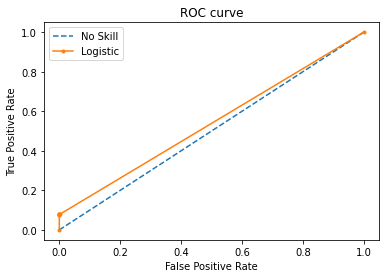


Confusion Matrix:
[[1463209     481]
 [   1889     161]]

../Data/Acc/ch_gps10_S1/15.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/17.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/16.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/12.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/13.npz

Dive detected. Stacking arrays with no dives.


In [ ]:
no_dives = []

for file in test_files:
    print('\n' + file + '\n')
    
    # Load file 
    arr = np.load(file)
    arr = arr[arr.files[0]]
    
    no_dives = process_files(arr, no_dives)

if no_dives:
    process_files(no_dives=no_dives)


../Data/Acc/ch_gps10_S1/8.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/9.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/14.npz

Dive detected. Stacking arrays with no dives.
2863/2863 [==============================] - 27s 9ms/step - loss: 818.1418 - accuracy: 0.9986


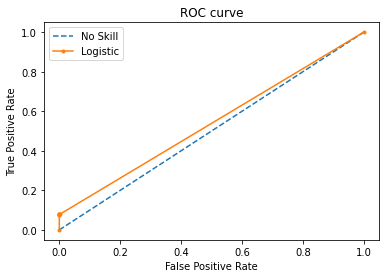


Confusion Matrix:
[[1463209     481]
 [   1889     161]]

../Data/Acc/ch_gps10_S1/15.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/17.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/16.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/12.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/13.npz

Dive detected. Stacking arrays with no dives.
4759/4759 [==============================] - 89s 19ms/step - loss: 1301787.3750 - accuracy: 0.9517


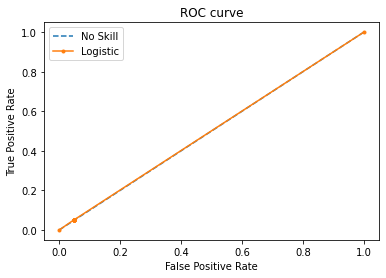


Confusion Matrix:
[[2318722  116221]
 [   1448      77]]

../Data/Acc/ch_gps10_S1/11.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/10.npz

Dive detected. Stacking arrays with no dives.
1906/1906 [==============================] - 13s 7ms/step - loss: 693.6553 - accuracy: 0.9986


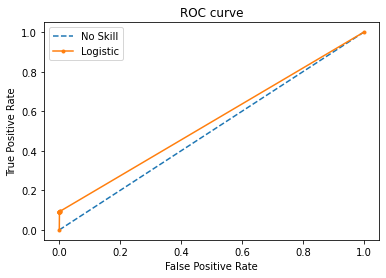


Confusion Matrix:
[[972923   1825]
 [   725     75]]

../Data/Acc/ch_gps10_S1/18.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/19.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/4.npz

Dive detected. Stacking arrays with no dives.
2018/2018 [==============================] - 14s 7ms/step - loss: 12173532.0000 - accuracy: 0.6506


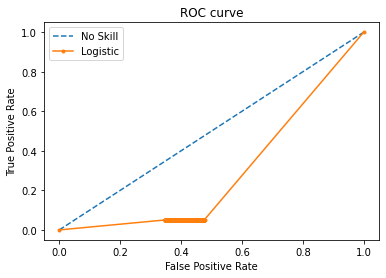


Confusion Matrix:
[[671325 360846]
 [   711     39]]

../Data/Acc/ch_gps10_S1/5.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/7.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/6.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/2.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/3.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/1.npz

No dives detected. Saved for the next run a dive is encountered.

../Data/Acc/ch_gps10_S1/0.npz

No dives detected. Saved for the next run a dive is encountered.


In [136]:
from sklearn.metrics import roc_curve, confusion_matrix
from matplotlib import pyplot
import numpy as np

no_dives = []

for file in test_files:
    print('\n' + file + '\n')
    
    # Load file 
    arr = np.load(file)
    arr = arr[arr.files[0]]
    
    # If no dives then save to concat with arr with dives later
    if (arr[:,-1] == 0).all():
        no_dives.append(arr)
        print('No dives detected. Saved for the next run a dive is encountered.')
        continue
    
    if no_dives:
        print('Dive detected. Stacking arrays with no dives.')
        no_dives.append(arr)
        arr = np.vstack(no_dives)
        no_dives = [] # reinitialise
    
    # Take x and y
    test_x = arr[:,:-1]
    test_y = arr[:,-1]
    
    # Evaluate
    model.evaluate(test_x, test_y, batch_size=512)

    # Predictions
    y_pred = model.predict(test_x, batch_size=512)

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(test_y, y_pred)

    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.xlabel('False Positive Rate') 
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title('ROC curve')
    pyplot.show()
    
    # Calculate optimal threshold
    gmeans = np.sqrt(tpr * (1-fpr))  # calculate the g-mean for each threshold
    ix = np.argmax(gmeans)
    threshold = thresholds[ix] # threshold with largest gmean
    
    # Confusion matrix
    #threshold = 0.5
    Y_pred = [1 * (x[0]>=threshold) for x in y_pred]
    conf = confusion_matrix(test_y, Y_pred)

    print('\nConfusion Matrix:')
    print(conf)

## H20

In [67]:
import numpy as np
import h2o
h2o.init(max_mem_size = "250G")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 3 hours 41 mins
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_lukeswaby_petts_6c51o3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,250.0 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [68]:
import time
t = time.time()
data = np.load('../Data/acc_train_data.npy')
df = h2o.H2OFrame(data) 
print(time.time() - t)
# currently: Error: Total input file size of 69.94 GB is much larger than total cluster memory of 1.29 GB, 
# please use either a larger cluster or smaller data.

KeyboardInterrupt: 

# Load each array and save stats to dict with pickle

In [46]:
import glob
import numpy as np
import pickle

dirs = glob.glob('../Data/Acc/*/') 
stats = {}

for dirr in dirs:
    files = glob.glob(f'{dirr}*.npz')
    ones = 0
    zeros = 0
    for file in files:
        dta = np.load(file)
        dta = dta[dta.files[0]]
        no = np.count_nonzero(dta[:,-1] == 0)  # no. of non-dives
        yes = np.count_nonzero(dta[:,-1] == 1)  # no. of dives
        ones += yes
        zeros += no
        del dta
    stats[dirr.split('/')[-2]] = {'Dives': ones, 'Non-dives': zeros, 'Proportion': '%.2f' % ((ones/zeros)*100) + '%'}

filename = '../Data/Acc/birds_dive_stats.pickle'
outfile = open(filename, 'wb')
pickle.dump(stats, outfile)
outfile.close()

### Load file

In [125]:
import pickle
filename = '../Data/Acc/birds_dive_stats.pickle'
infile = open(filename, 'rb')
bird_stats = pickle.load(infile)
infile.close()

In [65]:
import pandas as pd
pd.DataFrame.from_dict(bird_stats, orient='index')

,Dives,Non-dives,Proportion
ch_gps07_gv37846_20190206_S1,4350,8480502,0.05%
ch_gps11_gv37849_20190206_S1,14750,6894877,0.21%
ch_gps10_S1,5125,9317727,0.06%
ch_gps12_S1,10300,8880802,0.12%
ch_gps16_S1,36275,8654027,0.42%
ch_gps03_S1,33250,12465527,0.27%
ch_gps13_S1,19900,12496252,0.16%
ch_gps08_S1,25525,11317502,0.23%
ch_gps09_S1,8525,9335952,0.09%
